# Faces recognition Using SVM and Naives Bayes with PCA

In [1]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt
import pandas
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

print(__doc__)
%matplotlib inline

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


Download the data, if not already on disk and load it as numpy arrays


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
from collections import Counter

print("target names: %s" % target_names)
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

target names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


ground true label for selected example:  George W Bush


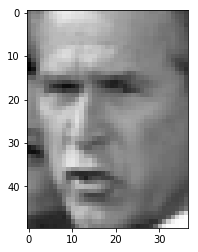

In [3]:
index = 30
plt.imshow(lfw_people.images[index,:,:],cmap='gray')
for i, name in enumerate(target_names):
    if i == y[index]:
        print("ground true label for selected example: ", name)

Split into a training set and a test set using a stratified k fold


In [4]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
dataset): unsupervised feature extraction / dimensionality reduction


In [5]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.395s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.026s


Train a SVM classification model


In [6]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 18.103s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Quantitative evaluation of the model quality on the test set


In [7]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.049s
                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.38      0.50        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.60      0.75        15
       Tony Blair       0.96      0.75      0.84        36

        micro avg       0.85      0.85      0.85       322
        macro avg       0.88      0.72      0.78       322
     weighted avg       0.86      0.85      0.84       322

[[  5   2   0   6   0   0   0]
 [  1  52   0   7   0   0   0]
 [  0   1  18   8   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   3   0   2   1   9   0]
 [  1   1   2   5   0   0  27]]


In [8]:
array_PCA = confusion_matrix(y_test, y_pred, labels=range(n_classes))
df_cm_PCA = pandas.DataFrame(array_PCA, index = [i for i in target_names],
                  columns = [i for i in target_names])

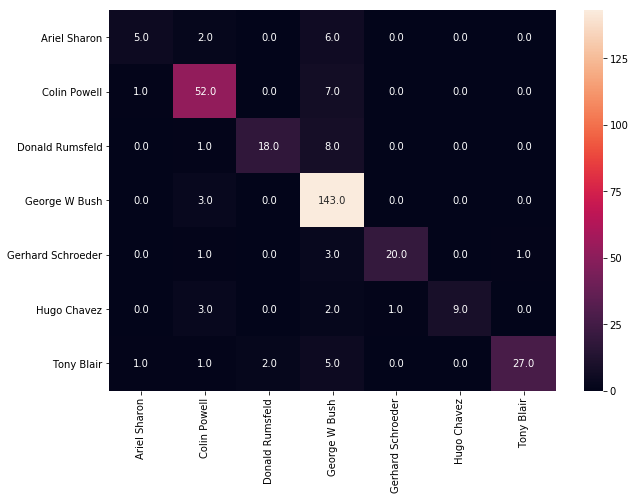

In [9]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_PCA, annot=True, fmt=".1f")

In [10]:
from collections import Counter
number_per_classes = Counter(y_test)
print(number_per_classes)

Counter({3: 146, 1: 60, 6: 36, 2: 27, 4: 25, 5: 15, 0: 13})


Qualitative evaluation of the predictions using matplotlib


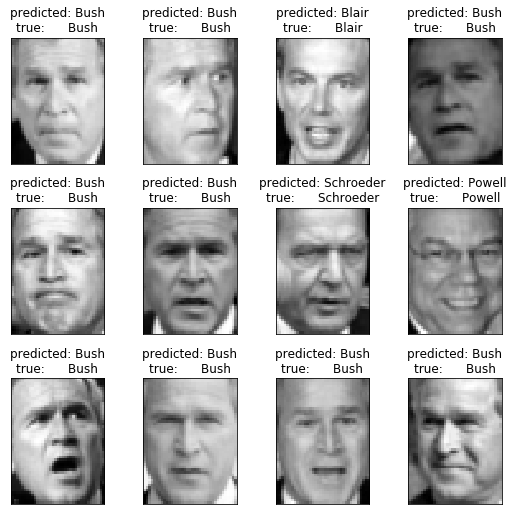

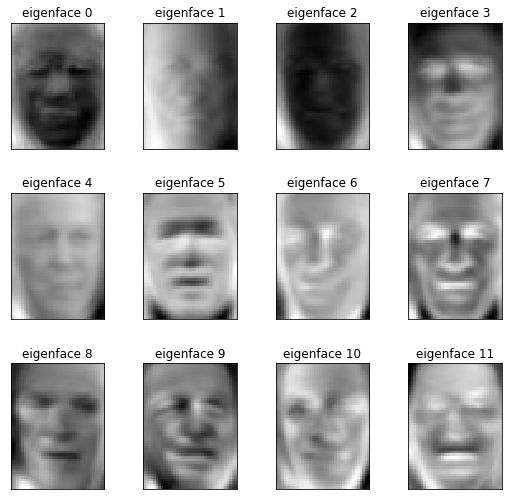

In [11]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# Naive Bayes Classifier !!

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [13]:
def classify(features_train, labels_train):   
    clf_Bayes = GaussianNB()
    return clf_Bayes.fit(features_train, labels_train)
    

def NB_accuracy(features_train, labels_train, features_test, labels_test):
    """ compute the accuracy of your Naive Bayes classifier as a seperate method """

    clf_Bayes = GaussianNB()
    clf_Bayes.fit(features_train, labels_train)

    pred = clf_Bayes.predict(features_test)

    accuracy = accuracy_score(labels_test, pred)
    return accuracy

In [14]:
accuracy_NB = NB_accuracy(X_train, y_train, X_test, y_test)
print('Accuracy NB = %.2f %%' % (100*accuracy_NB))

Accuracy NB = 41.30 %


In [15]:
clf_Bayes = classify(X_train, y_train)

In [16]:
clf_Bayes.predict([X_test[10]])

array([3])

In [17]:
y_test[10]

3

In [18]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf_Bayes.predict(X_test)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.025s
                   precision    recall  f1-score   support

     Ariel Sharon       0.16      0.23      0.19        13
     Colin Powell       0.45      0.38      0.41        60
  Donald Rumsfeld       0.32      0.44      0.37        27
    George W Bush       0.76      0.45      0.57       146
Gerhard Schroeder       0.26      0.24      0.25        25
      Hugo Chavez       0.13      0.53      0.21        15
       Tony Blair       0.34      0.42      0.37        36

        micro avg       0.41      0.41      0.41       322
        macro avg       0.35      0.39      0.34       322
     weighted avg       0.53      0.41      0.44       322

[[ 3  3  4  1  0  1  1]
 [ 5 23  9  9  0  8  6]
 [ 7  4 12  1  2  0  1]
 [ 4 14  9 66 10 27 16]
 [ 0  1  1  4  6  8  5]
 [ 0  2  0  2  3  8  0]
 [ 0  4  3  4  2  8 15]]


In [19]:
array_NB = confusion_matrix(y_test, y_pred, labels=range(n_classes))
df_cm_NB = pandas.DataFrame(array_NB, index = [i for i in target_names],
                  columns = [i for i in target_names])

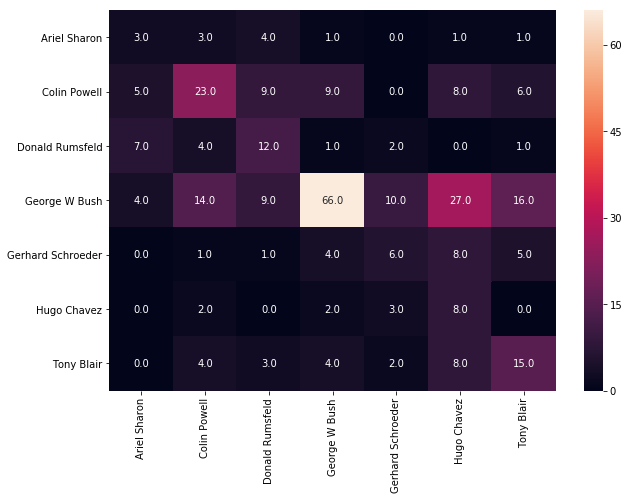

In [20]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_NB, annot=True, fmt=".1f")

# Naive Bayes with PCA

In [21]:
accuracy_NB_PCA = NB_accuracy(X_train_pca, y_train, X_test_pca, y_test)
print('Accuracy NB PCA = %.2f %%' % (100*accuracy_NB_PCA))

Accuracy NB PCA = 72.67 %


In [22]:
clf_Bayes_PCA = classify(X_train_pca, y_train)

In [23]:
clf_Bayes_PCA.predict([X_test_pca[120]])

array([1])

In [24]:
y_test[120]

1

In [25]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf_Bayes_PCA.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.004s
                   precision    recall  f1-score   support

     Ariel Sharon       0.20      0.38      0.26        13
     Colin Powell       0.75      0.67      0.71        60
  Donald Rumsfeld       0.82      0.52      0.64        27
    George W Bush       0.76      0.89      0.82       146
Gerhard Schroeder       0.70      0.56      0.62        25
      Hugo Chavez       0.75      0.40      0.52        15
       Tony Blair       0.86      0.69      0.77        36

        micro avg       0.73      0.73      0.73       322
        macro avg       0.69      0.59      0.62       322
     weighted avg       0.75      0.73      0.73       322

[[  5   1   0   6   0   0   1]
 [  5  40   1  14   0   0   0]
 [  4   2  14   3   3   0   1]
 [  7   7   1 130   0   1   0]
 [  0   0   0   8  14   1   2]
 [  2   2   0   4   1   6   0]
 [  2   1   1   5   2   0  25]]


In [26]:
array_NB_PCA = confusion_matrix(y_test, y_pred, labels=range(n_classes))
df_cm_NB_PCA = pandas.DataFrame(array_NB_PCA, index = [i for i in target_names],
                  columns = [i for i in target_names])

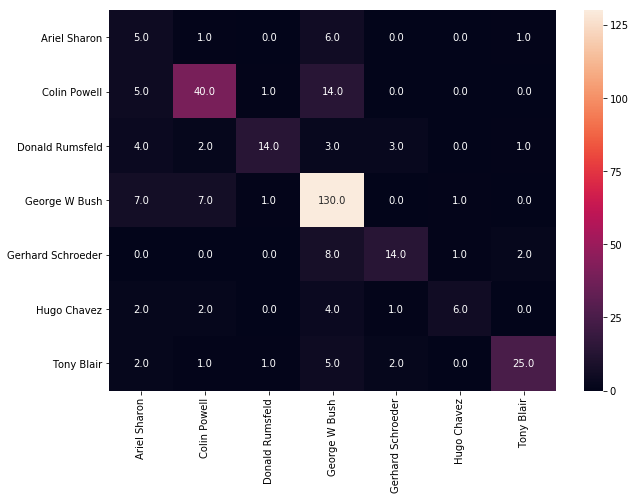

In [27]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_NB_PCA, annot=True, fmt=".1f")